# 05. 텍스트 유사도
**텍스트 유사도 문제** : 두 문장(글)이 있으 ㄹ때 두 문장 간의 유사도를 측정할 수 있는 모델을 만드는 것.  

kaggle의 대회 중 하나를 해결해보자.  
"Quora Questions Pairs"라는 문제로, 쿼라(Quora)는 질문을 하고 다른 사용자들로부터 답변을 받을 수 있는 서비스.  
여러 질문들 중에서 어떤 질문이 서로 유사한지 판단하는 모델을 만든느 것이 이번 장의 목표.  

## 1. 문제 소개
- 데이터 출처
`https://www.kaggle.com/c/quora-question-pairs/data`

쿼라 입장에서 중복된 질문들을 잘 찾기만 하면 이미 잘 작성된 답변들을 사용자들이 참고하게 할 수 있고, 더 좋은 서비스를 제공할 수 있음!  
참고로 쿼라에서는 현재 이미 중복에 대한 검사를 하고 있고, 앞서 배운 랜덤 포레스트 모델을 통해 중복 질문들을 찾고 있음.  

## 2. 데이터 분석과 전처리
데이터 분석을 통해 데이터의 특징을 파악하고 이를 바탕으로 데이터 전처리 작업을 진행.  
주로 문장의 길이와 어휘 빈도 분석을 해서 그 결과를 전처리에 적용하고자 함.  
데이터를 내려받는 것부터 시작해서 데이터를 분석한 후 전처리하는 순서로 진행.  

### 데이터 불러오기와 분석하기

`kaggle competitions download -c quora-question-pairs`

데이터 종류  
- sample_submission.csv.zip : 우리가 만들 모델을 통해 평가 데이터에 대한 예측 결과를 캐글 홈페이지에 제출할 때 양식을 맞추기 위해 보여주는 예시 파일
- test.csv.zip : 평가 데이터
- train.csv.zip : 테스트 데이터

In [4]:
import zipfile

DATA_IN_PATH = './data_in/'
file_list = ['train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']

for file in file_list : 
    zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
    zipRef.extractall(DATA_IN_PATH)
    zipRef.close()

본격적으로 데이터를 불러온 후 데이터 분석을 해보자.

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

학습 데이터를 불러와 어떤 형태로 데이터가 구성돼 있는지 확인해 보자.

In [6]:
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
train_data.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

- id ; 각 행 데이터의 고유한 인덱스 값
- qid1, qid2 : 각 질문의 고유한 인덱스
- question1, question2 : 각 질문의 내용
- is_duplicat : 0이면 두 개의 질문이 중복이 아니고 1이면 두 개의 질문이 중복

이제 사용할 데이터가 어떤 데이터이고, 크기가 어느 정도 되는지 출력해보자.

In [7]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH) :
    if 'csv' in file and 'zip' not in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file)/1000000, 2)) + "MB")

파일 크기 : 
sample_submission.csv         22.35MB
test.csv                      477.59MB
train.csv                     63.4MB


파일 크기를 보면 대부분 훈련 데이터가 평가 데이터보다 큰데, 이 데이터의 경우 테스트 데이터가 훨씬 크다.  
그 이유는 쿼라의 경우 질문에 대해 데이터의 수가 적다면 각각을 검색을 통해 중복을 찾아내는 편법을 사용할 수 있기 때문.  

먼저 학습 데이터의 개수를 알아보자.  

In [10]:
print("전체 학습 데이터의 개수 : {}".format(len(train_data)))

전체 학습 데이터의 개수 : 404290


전체 질문 쌍의 개수는 40만 개.  
dataframe이 행렬 구조라면 series는 인덱스를 가지고 있는 배열.  
지금 하나의 데이터에 두 개의 지룸ㄴ이 있는 구조인데, 전체 질문(두 개의 질문)을 한번에 분석하기 위해 판다스의 시리즈를 통해 두 개의 질문을 하나로 합친다.  

참고로 앞으로 진행할 분석 순서는 질문 중복 분석, 라벨 빈도 분석, 문자 분석, 단어 분석!  

첫번째, 질문 중복 분석부터 시작

In [13]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str) # astype은 원하는 변수형으로 바꿔주는것
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

이제 질문들의 중복 여부를 확인해 보자.  
넘파이를 이용해 중복을 제거한 총 질문의 수와 반복해서 나오는 질문의 수를 확인하자.

In [18]:
print('교육 데이터의 총 질문 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 질문의 수 : {}'.format(np.sum(train_set.value_counts() > 1)))

교육 데이터의 총 질문 수 : 537361
반복해서 나타나는 질문의 수 : 111873


중복을 제거한 유일한 질문값만 확인하기 위해 넘파이의 unique함수 사용.  
중복되는 질문의 정확한 개수를 확인하기 위해 2개 이상의 값을 가지는 질문인 value_counts가 2 이상인 값의 개수를 모두 더함. 

In [20]:
len(train_set)

808580

In [21]:
train_set.value_counts()

What are the best ways to lose weight?                                                                                      161
How can you look at someone's private Instagram account without following them?                                             120
How can I lose weight quickly?                                                                                              111
What's the easiest way to make money online?                                                                                 88
Can you see who views your Instagram?                                                                                        79
                                                                                                                           ... 
What was your mental hospital stay like?                                                                                      1
Too lazy to go visit a doctor but you guys can help me in here right? my tongue is of this colour for th

결과를 보면 80만 개의 데이터에서 53만 개가 유니크 데이터이므로 27만개가 중복돼 있고, 27만 개의 데이터는 11만 개 데이터의 고유한 질문으로 이뤄져 있음.

이제 matplotlib을 통해 시각화해 보자.  
'question' 값들의 개수를 보여주며 x축은 중복 개수, y값은 동일한 중복 횟수를 가진 질문의 개수를 의미

Text(0, 0.5, 'Number of questions')

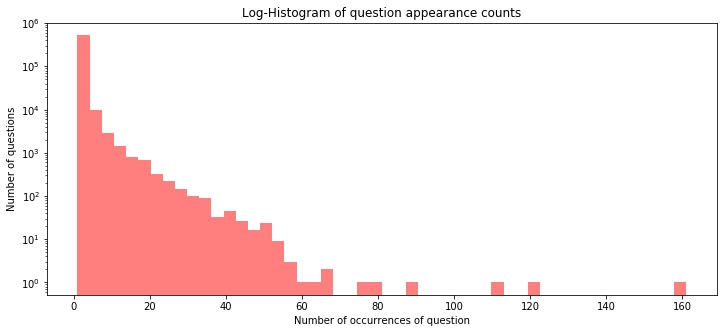

In [22]:
plt.figure(figsize = (12, 5))

plt.hist(train_set.value_counts(), bins = 50, alpha = 0.5, color = 'r', label = 'word')

plt.yscale('log', nonposy = 'clip')

plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')

중복 횟수가 1인 질문 = 유일한 질문이 가장 많고, 대부분의 질문이 중복 횟수가 50버 ㄴ이하.  
그리고 매우 큰 빈도를 가진 질문은 이상치임.  

질문의 중복 분포를 통계치로 수치화해서 다른 방향으로 확인해보자. 

In [23]:
print('중복 최대 개수 : {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수 : {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수 : {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차 : {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이 : {}'.format(np.median(train_set.value_counts())))
print('제1사분위 중복 : {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제3사분위 중복 : {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수 : 161
중복 최소 개수 : 1
중복 평균 개수 : 1.50
중복 표준편차 : 1.91
중복 중간길이 : 1.0
제1사분위 중복 : 1.0
제3사분위 중복 : 1.0


중복 발생 횟수의 평균이 1.5라는 것으느 많은 데이터가 최소 1개 이상 중복돼 있음을 의미.  
즉, 중복이 많다는 뜻.  
이제 박스 플롯을 통해 중복 횟수와 관련해서 데이터를 직관적으로 이해해 보자.

{'whiskers': [<matplotlib.lines.Line2D at 0x16dc0059788>,
 'caps': [<matplotlib.lines.Line2D at 0x16dc005c088>,
 'boxes': [<matplotlib.lines.Line2D at 0x16dc00779c8>],
 'medians': [<matplotlib.lines.Line2D at 0x16dbccef688>],
 'fliers': [<matplotlib.lines.Line2D at 0x16dc005be88>],
 'means': [<matplotlib.lines.Line2D at 0x16dc005dac8>]}

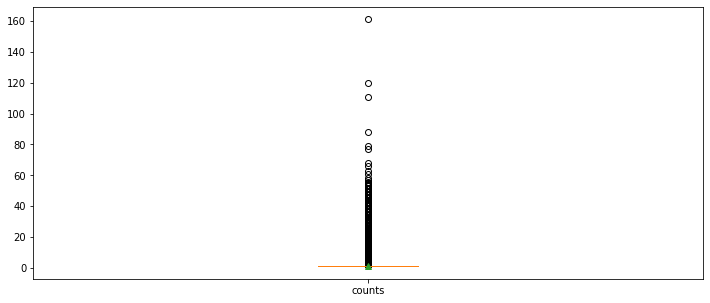

In [24]:
plt.figure(figsize = (12, 5))
# 박스 플롯 생성
# 첫 번째 파라미터 : 여러 분포에 대한 데이터 리스트를 입력
# labels : 입력한 데이터에 대한 라벨
# showmeans : 평균값을 마크함

plt.boxplot([train_set.value_counts()], 
           labels = ['counts'],
           showmeans = True)

중복 횟수의 이상치(outliers)가 너무 넓고 많이 분포해서 박스 플롯의 다른 값을 확인하기조차 어려운 데이터.  
이번에는 워드클라우드로 어떤 단어가 많이 나오는지 확인해보자.

(-0.5, 799.5, 599.5, -0.5)

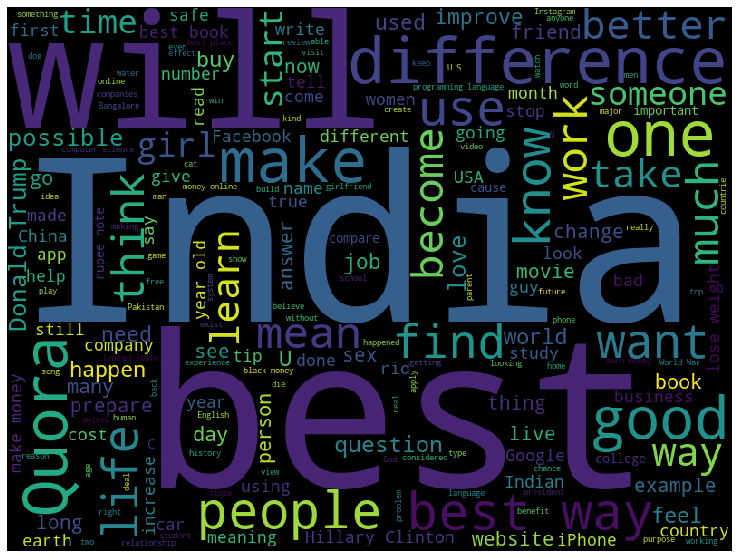

In [25]:
from wordcloud import WordCloud
cloud = WordCloud(width = 800, height = 600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(cloud)
plt.axis('off')

best, way, good, difference 등의 단어들이 질문 할 때 많이 사용된다는 것을 알 수 있음.  
특이한 점은 'Donald Trump'가 존재하는 것.  
이는 선거 기간 중 학습 데이터를 만들었기 때문.  

이제 질문 텍스트가 아닌 데이터의 라벨인 'is_duplicate'에 대해 알아보자.  
라벨의 경우 질문이 중복인 경우인 1 값과 중복이 아닌 0 값이 존재.  
라벨들의 횟수에 대해 그래프를 그려보자. 

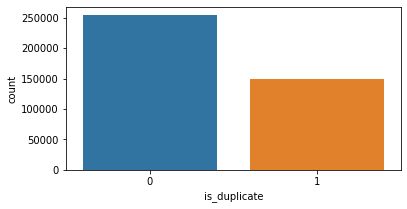

In [27]:
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['is_duplicate'])

중복이 아닌 데이터가 25만 개, 중복된 데이터가 15만 개.  
이 상태로 학습한다면 중복이 아닌 데이터 25만 개에 의존도가 높아지면서 데이터가 한쪽 라벨로 편향 됨.  

이러한 경우 학습이 원활하게 되지 않을 수 있으므로 최대한 라벨의 개수를 균형 있게 맞춰준 후 진행하는 것이 좋음.  
많은 수의 데이터를 줄이거나 적은 수의 데이터를 늘린 후 학습.

다음으로 텍스트 데이터의 길이를 분석해보자.  
문자 단위로 먼저 길이를 분석한 후 단어 단위로 길이를 분석한다.

In [28]:
train_length = train_set.apply(len)

C:\Users\nyong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Probability')

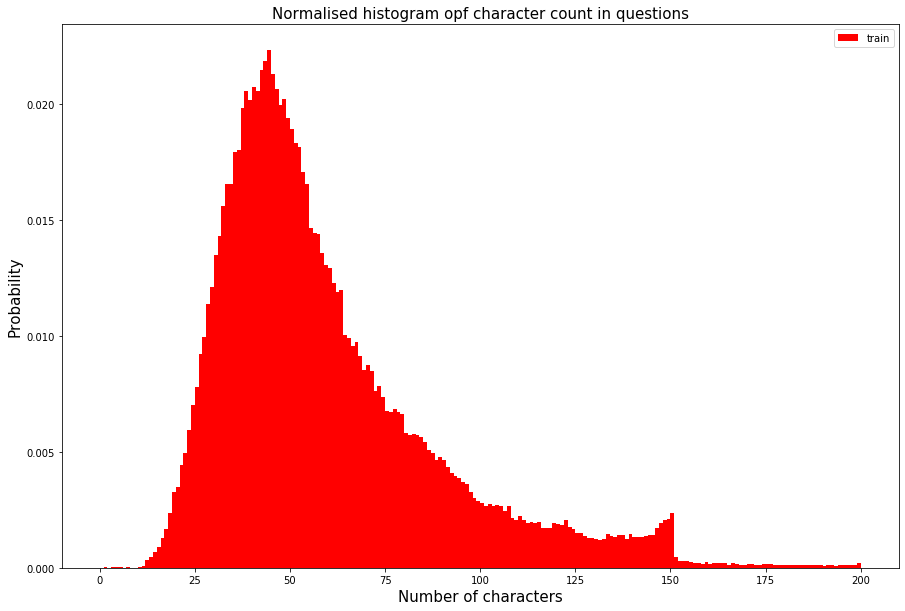

In [29]:
plt.figure(figsize = (15, 10))
plt.hist(train_length, bins = 200, range = [0, 200], facecolor = 'r', normed = True, label= 'train')
plt.title("Normalised histogram opf character count in questions", fontsize = 15)
plt.legend()
plt.xlabel('Number of characters', fontsize= 15)
plt.ylabel("Probability", fontsize = 15)

데이터의 각 질문의 길이 분포는 15 ~ 150에 대부분 모여 있으며 길이가 150에서 급격하게 줄어든느 것을 볼 때 쿼라의 질문 길이 제한이 150 정도라는 것을 추정해 볼 수 있음.  

In [32]:
print('질문 길이 최댓값 : {}'.format(np.max(train_length)))
print('질문 길이 평균값 : {:.2f}'.format(np.mean(train_length)))
print('질문 길이 표준편차 : {:.2f}'.format(np.std(train_length)))
print('질문 길이 중간값 : {}'.format(np.median(train_length)))
print('질문 길이 제1사분위 : {}'.format(np.percentile(train_length, 25)))
print('질문 길이 제3사분위 : {}'.format(np.percentile(train_length, 75)))

질문 길이 최댓값 : 1169
질문 길이 평균값 : 59.82
질문 길이 표준편차 : 31.96
질문 길이 중간값 : 51.0
질문 길이 제1사분위 : 39.0
질문 길이 제3사분위 : 72.0


우선 평균적으로 질문 길이가 60정도라는 것.   
그리고 중간값도 겨우 51.  
하지만 최댓값은 1169로 평균, 중간값에 비해 매우 큰 차이를 보임.  
이런 데이터는 제외하고 학습하는 것이 좋음.  

이제 데이터의 질문 길이값에 대해서도 박스 플롯 그래프를 그려서 확인해보자.

{'whiskers': [<matplotlib.lines.Line2D at 0x16dc9811d08>,
 'caps': [<matplotlib.lines.Line2D at 0x16dc9812a08>,
 'boxes': [<matplotlib.lines.Line2D at 0x16dc980d5c8>],
 'medians': [<matplotlib.lines.Line2D at 0x16dc9817bc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x16dc98183c8>],
 'means': [<matplotlib.lines.Line2D at 0x16dc9818f88>]}

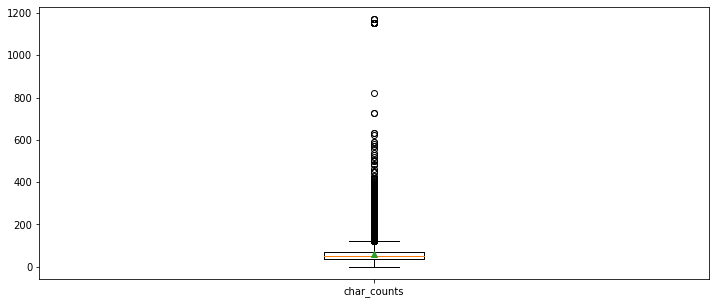

In [33]:
plt.figure(figsize = (12, 5))

plt.boxplot(train_length, 
           labels = ['char_counts'],
           showmeans = True)

분포를 보면 문자 수의 이상치 데이터가 너무 많이 분포해서 박스 플롯의 다른 값을 확인하기조차 어려운 상태.  

이제 문자를 한 단위로 하는 것이 아니라 각 데이터의 단어 개수를 하나의 단위로 사용해 길이값을 분석해 보자.  

In [35]:
train_word_counts = train_set.apply(lambda x : len(x.split(' ')))

C:\Users\nyong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Prabability')

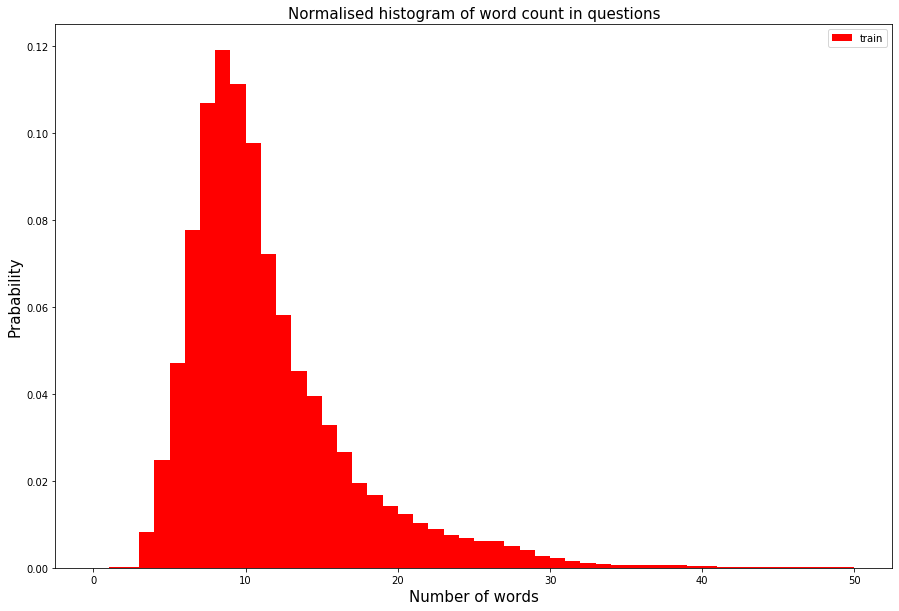

In [36]:
plt.figure(figsize = (15, 10))
plt.hist(train_word_counts, bins = 50, range = [0, 50], facecolor = 'r', normed = True, label = 'train')
plt.title('Normalised histogram of word count in questions', fontsize = 15)
plt.legend()

plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Prabability', fontsize = 15)

대부분 10개 정도의 단어로 구성된 데이터가 가장 많다는 것을 확인 가능.  
20개 이상부터는 매우 적어짐.  

In [37]:
print('질문 단어 개수 최댓값 : {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 평균값 : {:.2f}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 표준편차 : {:.2f}'.format(np.std(train_word_counts)))
print('질문 단어 개수 중간값 : {}'.format(np.median(train_word_counts)))
print('질문 단어 개수 제1사분위 : {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 제3사분위 : {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 99퍼센트 : {}'.format(np.percentile(train_word_counts, 99)))

질문 단어 개수 최댓값 : 237
질문 단어 개수 평균값 : 11.06
질문 단어 개수 표준편차 : 5.89
질문 단어 개수 중간값 : 10.0
질문 단어 개수 제1사분위 : 7.0
질문 단어 개수 제3사분위 : 13.0
질문 단어 개수 99퍼센트 : 31.0


평균 약 11개, 중간값도 10개, 최댓값은 237개.  

박스 플롯을 통해 데이터 분포를 다시 한 번 확인하자.

{'whiskers': [<matplotlib.lines.Line2D at 0x16dc98e67c8>,
 'caps': [<matplotlib.lines.Line2D at 0x16dbccde4c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x16dc98af848>],
 'medians': [<matplotlib.lines.Line2D at 0x16dc00327c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x16dc97ede08>],
 'means': [<matplotlib.lines.Line2D at 0x16dc002eb48>]}

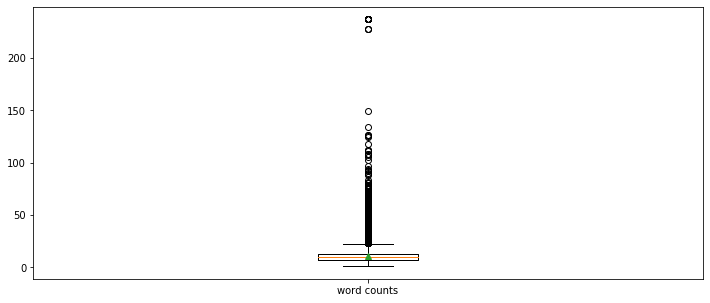

In [38]:
plt.figure(figsize = (12, 5))

plt.boxplot(train_word_counts,
           labels = ['word counts'],
           showmeans = True)

문자 길이에 대한 박스 플롯과 비슷한 모양.  
쿼라 데이터의 경우 이상치가 넓고 많이 분포돼 있음을 이를 통해 확인할 수 있다.  

이제 대부분 분석이 끝났다.  
마지막으로 몇 가지 특정 경우에 대한 비율을 확인해 보자. 

In [42]:
qmarks = np.mean(train_set.apply(lambda x : '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x : '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x : '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x : x[0].isupper())) # 첫 번째 대문자
capitals = np.mean(train_set.apply(lambda x : max([y.isupper() for y in x ]))) # 대문자 몇 개인지
numbers = np.mean(train_set.apply(lambda x : max([y.isdigit() for y in x]))) # 숫자가 몇 개인지

print('물음표가 있는 질문 : {:.2f}%'.format(qmarks * 100))
print('수학 태그가 있는 질문 : {:.2f}%'.format(math * 100))
print('마침표가 있는 질문 : {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자인 질문 : {:.2f}%'.format(capital_first * 100))
print('대문자가 있는 질문 : {:.2f}%'.format(capitals * 100))
print('숫자가 있는 질문 : {:.2f}%'.format(numbers * 100))

물음표가 있는 질문 : 99.87%
수학 태그가 있는 질문 : 0.12%
마침표가 있는 질문 : 6.31%
첫 글자가 대문자인 질문 : 99.81%
대문자가 있는 질문 : 99.95%
숫자가 있는 질문 : 11.83%


대문자가 첫 글자인 질문과 물음표르 동반하는 질문이 99%이상.  
그럼 여기서 생각해볼 부분이 있음.  
즉, 모든 질문이 보편적으로 가지고 잇는 이 특징의 유지 여부에 대해서인데, **모두가 가지고 잇는 보편적인 특징은 여기서는 제거**  

질문 데이터의 중복 여부 분포, 즉 라벨의 분포가 크게 차이나서 학습에 편향을 제공하므로 좋지 않은 영향을 줄 수 있으므로 이를 전처리 과정에서 분포를 맞추고,  
대부분의 질문에 포함된 첫 번째 대문자는 소문자로 통일.  
물음표 같은 구두점은 삭제하는 식으로 보편적인 특성은 제거하여 필요한 부분만 학습하게 하는 이점을 얻을 수 있음.

####  데이터 전처리  

In [1]:

import pandas as pd
import numpy as np
import re
import json

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [13]:
DATA_IN_PATH = './data_in/'
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv', encoding = 'utf-8')

맨 먼저 진행할 전처리 과정은 앞서 분석 과정에서 확이냏ㅆ던 내용 중 하나인 라벨 개수의 균형을 맞추는 것.  
앞서 분석 과정에서 확인했듯이 중복이 아닌 데이터의 개수가 더욱 많으므로 해당 데이터 개수를 줄인 후 분석 진행.  

먼저 중복인 경우와 아닌 경우로 데이터를 나눈 후 중복이 아닌 개수가 비슷하도록 데이터의 일부를 다시 뽑자.
 
데이터프레임 객체의 **loc** 라는 기능을 활용해 데이터를 추출.  
이 기능을 사용해 라벨이 1인 경우와 0인 경우를 분리해서 변수를 생성.  

In [14]:
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1]
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0]



이제 두 변수의 길이를 맞춰야 함.  
우선 두 변수의 길이의 차이를 계산하고 샘플링하기 위해 적은 데이터(중복 질문)의 개수가 많은 데이터(중복이 아닌 질문)에 대한 비율 계산

In [15]:
len(train_neg_data)

255027

In [16]:
len(train_pos_data)

149263

In [17]:
class_difference = len(train_neg_data) - len(train_pos_data)
sample_frac = 1 - (class_difference / len(train_neg_data)) # 차이나는 것만큼을 줄여야하니까 비율 얼만큼을 줄여야하는지 계산하기 위해

train_neg_data = train_neg_data.sample(frac = sample_frac)

그러면 두 데이터 간의 개수가 거의 비슷해짐

In [19]:
print("중복 질문 개수 : {}".format(len(train_pos_data)))
print("중복이 아닌 질문 개수 : {}".format(len(train_neg_data)))

중복 질문 개수 : 149263
중복이 아닌 질문 개수 : 149263


이제 해당 데이터를 사용하면 균형 있게 학습할 수 있음.  
우선 라벨에 따라 나눠진 데이터를 다시 하나로 합치자.

In [21]:
train_data = pd.concat([train_neg_data, train_pos_data])

이제 전처리를 진행해보자.  

먼저 문장 문자열에 대해 진행한다.  
우선 학습 데이터의 질문 쌍을 하나의 질문 리스트로 만들고, 정규 표현식을 사용해 물음표와 마침표 같은 구두점 및 기호를 제거하고 모든 문자를 소문자로 바꾸는 처리를 한다.  

각 데이터에 있는 두 개의 질문을 각각 리스트 형태로 만든 후 각 리스트에 대해 전처리를 진행해서 두 개의 전처리된 리스트를 만들자.

In [25]:
FILTERS = "([~.,!?\"':;)(])" 
change_filter = re.compile(FILTERS) # 패턴 객체 만들기

questions1 = [str(s) for s in train_data['question1']]
questions2 = [str(s) for s in train_data['question2']]


filtered_questions1 = list()
filtered_questions2 = list()

for q in questions1 :
    filtered_questions1.append(re.sub(change_filter, "", q).lower())
    
for q in questions2 :
    filtered_questions2.append(re.sub(change_filter, "", q).lower())

이제 정제된 텍스트 데이터를 토크나이징하고 각 단어를 인덱스로 바꾼 후, 전체 데이터의 길이를 맞추기 위해 정의한 최대 길이보다 긴 문장은 자르고 짧은 문장은 패딩 처리. 

문자열 토크나이징은 앞과 동일하게 텐서플로 케라스에서 제공하는 자연어 전처리 모듈 활용.  
이때 토크나이징 객체를 만들 때는 두 질문 텍스트를 합친 리스트에 대해 적용하고, 토크나이징은 해당 객체를 활용해 각 질문에 대해 따로 진행.  
이러한 방법을 사용하는 이유는 두 질문에 대해 토크나이징 방식을 동일하게 진행하고, 두 질문을 하벼 전체 단어 사전을 만들기 위해서!  

토크나이징 후에는 패딩 처리를 한 벡터화 진행

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_questions1 + filtered_questions2)

이렇게 생성한 토크나이징 객체를 두 질문 리스트에 적용해 각 질문을 토크나이징하고 단어들을 각 단어의 인덱스로 변환하자.

In [36]:
questions1_sequence = tokenizer.texts_to_sequences(filtered_questions1)
questions2_sequence = tokenizer.texts_to_sequences(filtered_questions2)

단어 인덱스로 이뤄진 벡터로 바꾼 값을 확인해 보면 어떤 구조로 바뀌었는지 확인할 수 있을 것.  
이제 모델에 적용하기 위해 특정 길이로 동일하게 맞춰야 함.  
따라서 최대 길이를 정한 후 그 길이보다 긴 질문은 자르고, 짧은 질문은 부족한 부분을 0으로 채우는 패딩 과정 진행

In [37]:
MAX_SEQUENCE_LENGTH = 31

In [38]:
q1_data = pad_sequences(questions1_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
q2_data = pad_sequences(questions2_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

최대 길이는 앞서 데이터 분석에서 확인했던 단어 개수의 99퍼센트인 31로 설정. (이상치를 뺀 나머지를 포함하기 위해서 - 다양한 값으로 실험해본 결과 이 값이 가장 좋았음)  

전처리가 끝난 데이터를 저장하자.  
저장하기 전에 라벨값과 단어 사전을 저장하기 위해 값을 저장한 후 각 데이터의 크기를 확인해 보자.

In [39]:
word_vocab = {}
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

labels = np.array(train_data['is_duplicate'], dtype = int)

print("Shape of question1 data : {}".format(q1_data.shape))
print("Shape of question2 data : {}".format(q2_data.shape))
print("Shape of label : {}".format(labels.shape))
print("Words in index : {}".format(len(word_vocab)))

Shape of question1 data : (298526, 31)
Shape of question2 data : (298526, 31)
Shape of label : (298526,)
Words in index : 76416


단어 사전과 전체 단어의 개수는 딕셔너리 형태로 저장해두자.

In [40]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [44]:
TRAIN_Q1_DATA = 'q1_train.npy'
TRAIN_Q2_DATA = 'q2_train.npy'
TRAIN_LABEL_DATA = 'label_train.npy'
DATA_CONFIGS = 'data_configs.npy'

np.save(open(DATA_IN_PATH + TRAIN_Q1_DATA, 'wb'), q1_data)
np.save(open(DATA_IN_PATH + TRAIN_Q2_DATA, 'wb'), q2_data)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), labels)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

넘파이의 save 함수를 활용해 각 질문과 라벨 데이터를 저장한다.  
딕셔너리 형태의 데이터 정보는 json 파일로 저장.  
이렇게 하면 학습할 모델에 대한 데이터 전처리가 완료된다.  

전처리한 데이터는 뒤에 모델 학습을 하는 과정에서 손쉽게 활용될 것이다.  

이제 평가 데이터에 대해서도 앞의 전처리 과정을 동일하게 진행한 후 전처리한 데이터를 저장하자.  

In [46]:
test_data = pd.read_csv(DATA_IN_PATH + 'test.csv', encoding = "utf-8")
valid_ids = [type(x) == int for x in test_data.test_id]
test_data = test_data[valid_ids].drop_duplicates()

평가 데이터의 길이가 학습 데이터와 비교했을 때 매우 길어 훨씬 시간이 많이 소요됨

In [47]:
test_questions1 = [str(s) for s in test_data['question1']]
test_questions2 = [str(s) for s in test_data['question2']]

filtered_test_questions1 = list()
filtered_test_questions2 = list()

for q in test_questions1 :
    filtered_test_questions1.append(re.sub(change_filter, "", q).lower())
    
for q in test_questions2 :
    filtered_test_questions2.append(re.sub(change_filter, "", q).lower())

정확히는 평가 데이터를 인덱스 벡터로 만든 후 동일하게 패딩 처리를 하면 됨.  
이때 사용하는 토크나이징 객체는 이전에 학습 데이터에서 사용했던 객체를 사용해야 동일한 인덱스를 가짐

In [48]:
test_questions1_sequence = tokenizer.texts_to_sequences(filtered_test_questions1)
test_questions2_sequence = tokenizer.texts_to_sequences(filtered_test_questions2)

In [49]:
test_q1_data = pad_sequences(test_questions1_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
test_q2_data = pad_sequences(test_questions2_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

평가 데이터의 경우 라벨이 존재하지 않으므로 라벨은 저장할 필요 없음.  

하지만 평가 데이터에 대한 결과를 캐글에 제출할 때 평가 데이터의 id 값이 필요함.  
따라서 평가 데이터의 id값을 넘파이 배열로 만들자.  
그리고 평가 데이터를 전처리한 값들의 크기를 출력해보자.

In [51]:
test_id = np.array(test_data['test_id'])

print('Shape of questions1 data : {}'.format(test_q1_data.shape))
print("Shape of questions2 data : {}".format(test_q2_data.shape))
print('Shape of ids : {}'.format(test_id.shape))

Shape of questions1 data : (2345796, 31)
Shape of questions2 data : (2345796, 31)
Shape of ids : (2345796,)


이제 전처리한 평가 데이터를 파일로 저장하자.

In [68]:
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_Q1_DATA, 'wb'), test_q1_data)
np.save(open(DATA_IN_PATH + TEST_Q2_DATA, 'wb'), test_q2_data)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)